In [1]:
import torch.optim as optim

import dac
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio
import soundfile as sf
import numpy as np
import random
from torchaudio.functional import add_noise
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio
import matplotlib.pyplot as plt

In [2]:
root_dir = './data/'
clean_dir = root_dir + 'voice_fullband/'
noise_dir = root_dir + 'noise_fullband/'

batch_size = 4

In [3]:
def audio_collate_fn(batch):
    """
    Collate function to process the data batch by padding or trimming waveforms to the same length,
    then adding noise to the clean waveforms in a batch operation.
    
    Args:
        batch: List of tuples (clean_waveform, noise_waveform).
    
    Returns:
        A tuple containing two tensors: noisy_waveforms, clean_waveforms
    """
    target_length = 16384*4  # target size

    # Initialize lists to store processed waveforms
    processed_clean_waveforms = []
    processed_noise_waveforms = []

    # Process each sample in the batch
    for clean_waveform, noise_waveform in batch:
        current_length = clean_waveform.size(0)

        # If the waveform is shorter than the target length, we pad it
        if current_length < target_length:
            # Pad the waveforms to the target length
            padded_clean_waveform = torch.nn.functional.pad(clean_waveform, (0, target_length - current_length))
            padded_noise_waveform = torch.nn.functional.pad(noise_waveform, (0, target_length - current_length))
        else:
            # Randomly select a start point for trimming if waveform is longer than target
            start = torch.randint(0, current_length - target_length + 1, (1,)).item()
            end = start + target_length

            # Trim the waveforms to the target length
            padded_clean_waveform = clean_waveform[start:end]
            padded_noise_waveform = noise_waveform[start:end]

        # Add the processed waveforms to the lists
        processed_clean_waveforms.append(padded_clean_waveform)
        processed_noise_waveforms.append(padded_noise_waveform)

    # Stack all the processed waveforms together to create batches
    batched_clean_waveforms = torch.stack(processed_clean_waveforms)
    batched_noise_waveforms = torch.stack(processed_noise_waveforms)

    snr_value = 10  # signal-to-noise ratio in dB
    snr_tensor = torch.tensor([snr_value], dtype=torch.float32)

    # The following line adds noise to the batch of clean waveforms to create noisy waveforms
    noisy_waveforms = add_noise(batched_clean_waveforms, batched_noise_waveforms, snr_tensor).view(-1, 1, target_length)
    batched_clean_waveforms = batched_clean_waveforms.view(-1, 1, target_length)

    return noisy_waveforms, batched_clean_waveforms

In [4]:
class MixedAudioDataset(Dataset):
    def __init__(self, clean_dir, noise_dir):
        """
        Args:
            clean_dir (string): Directory with all the clean audio files.
            noise_dir (string): Directory with all the noise audio files.
            snr_value (float): The signal-to-noise ratio to be applied when mixing noise with the clean audio.
        """
        self.clean_dir = clean_dir
        self.noise_dir = noise_dir
        self.clean_file_list = self._get_file_list(clean_dir)
        self.noise_file_list = self._get_file_list(noise_dir)

    def _get_file_list(self, directory):
        # Walk the directory to get the list of audio files
        file_list = []
        for subdir, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith('.wav'):
                    file_list.append(os.path.join(subdir, file))
        return file_list

    def __len__(self):
        # The length is determined by the number of clean files
        return len(self.clean_file_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the clean and noise audio paths
        clean_audio_path = self.clean_file_list[idx]
        noise_audio_path = random.choice(self.noise_file_list)  # Randomly select a noise file
        
        # Load the clean and noise waveforms
        clean_waveform, _ = sf.read(clean_audio_path, dtype='float32')
        noise_waveform, _ = sf.read(noise_audio_path, dtype='float32')

        clean_waveform = torch.from_numpy(clean_waveform)
        noise_waveform = torch.from_numpy(noise_waveform)

        # Ensure noise is the same length as the clean waveform
        min_len = min(len(clean_waveform), len(noise_waveform))
        clean_waveform = clean_waveform[:min_len]
        noise_waveform = noise_waveform[:min_len]

        return clean_waveform.squeeze(0), noise_waveform.squeeze(0)


# Now you can create an instance of the MixedAudioDataset and retrieve a noisy and clean pair
MAD = MixedAudioDataset(clean_dir=clean_dir, noise_dir=noise_dir)

DL = DataLoader(MAD, batch_size=1, shuffle=True, collate_fn=audio_collate_fn)

In [5]:
noise, clean = next(iter(DL))
noise = noise.cuda()

In [6]:
model_path = dac.utils.download(model_type="44khz")
model = dac.DAC.load(model_path).cuda()

In [7]:
out = model(noise)["audio"]

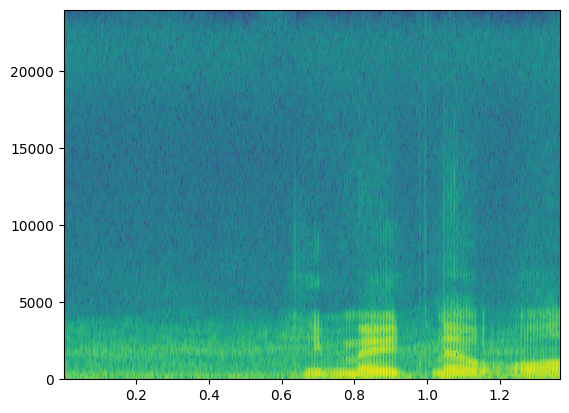

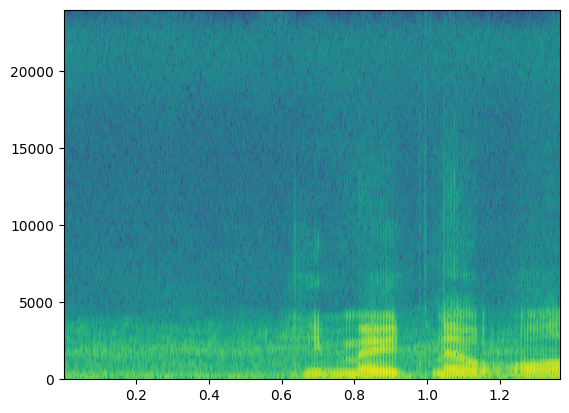

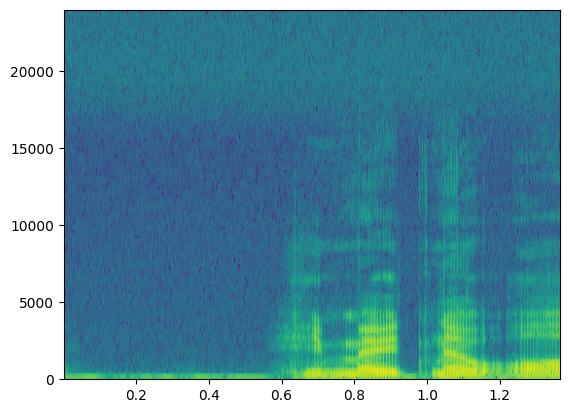

In [10]:
plt.specgram(out[0].cpu().detach().numpy().squeeze(), Fs=48000)
plt.show()
plt.specgram(clean[0].cpu().detach().numpy().squeeze(), Fs=48000)
plt.show()